<center>
<img src="https://supportvectors.ai/logo-poster-transparent.png" width="400px" style="opacity:0.7">
</center>

In [1]:
%run supportvectors-common.ipynb


<div style="color:#aaa;font-size:8pt">
<hr/>
&copy; SupportVectors. All rights reserved. <blockquote>This notebook is the intellectual property of SupportVectors, and part of its training material. 
Only the participants in SupportVectors workshops are allowed to study the notebooks for educational purposes currently, but is prohibited from copying or using it for any other purposes without written permission.

<b> These notebooks are chapters and sections from Asif Qamar's textbook that he is writing on Data Science. So we request you to not circulate the material to others.</b>
 </blockquote>
 <hr/>
</div>



# BERT embeddings

In this example, we demonstrate the typical anisotropy exhibited by a standard bert based model using the following approach: 
- Generate the embeddings created by the model on chunks of text across three different subjects - Physics, Biology, History.  
- PCA based 2-dimensional projection to bring down the high-dimensional vectors to 2-dimensions
- Visualize the 2-dimensional embeddings in a matplotlib to show how they all fall within a narrow angle on the plane.

**Model: `google-bert/bert-base-uncased`**

In [2]:
import torch
from sentence_transformers import SentenceTransformer
from contrastive_loss import config

Some utility functions for working with our custom dataset of subject chunks to bring them to hugging-face dataset format, and to be able to run evaluations on test data to evaluate the model performance.

In [3]:
from contrastive_loss.hf_text_utils import get_train_test_lists

## Load the Model from HuggingFace

In [4]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
device = 'cuda' if torch.cuda.is_available() else device
# Get the base huggingface model
model_name = "google-bert/bert-base-uncased"
model = SentenceTransformer(model_name).to(device)

We now do the following:

- create embeddings of sample text from our subject chunks folder
- use PCA to reduce dimensionality to 2 dimensions
- visualize these embeddings in matplotlib

In [5]:
# Retrieve all data labeled with subjects
all_data, _ = get_train_test_lists(cfg=config, split = 1.0)# Extract all sentences from the data
all_data = all_data[:1000]
data_sentences = [text for _, text in all_data]
labels = [label for label, _ in all_data]

# Encode the sentences
embeddings = model.encode(data_sentences)

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
pca_embeddings = pca.fit_transform(embeddings)

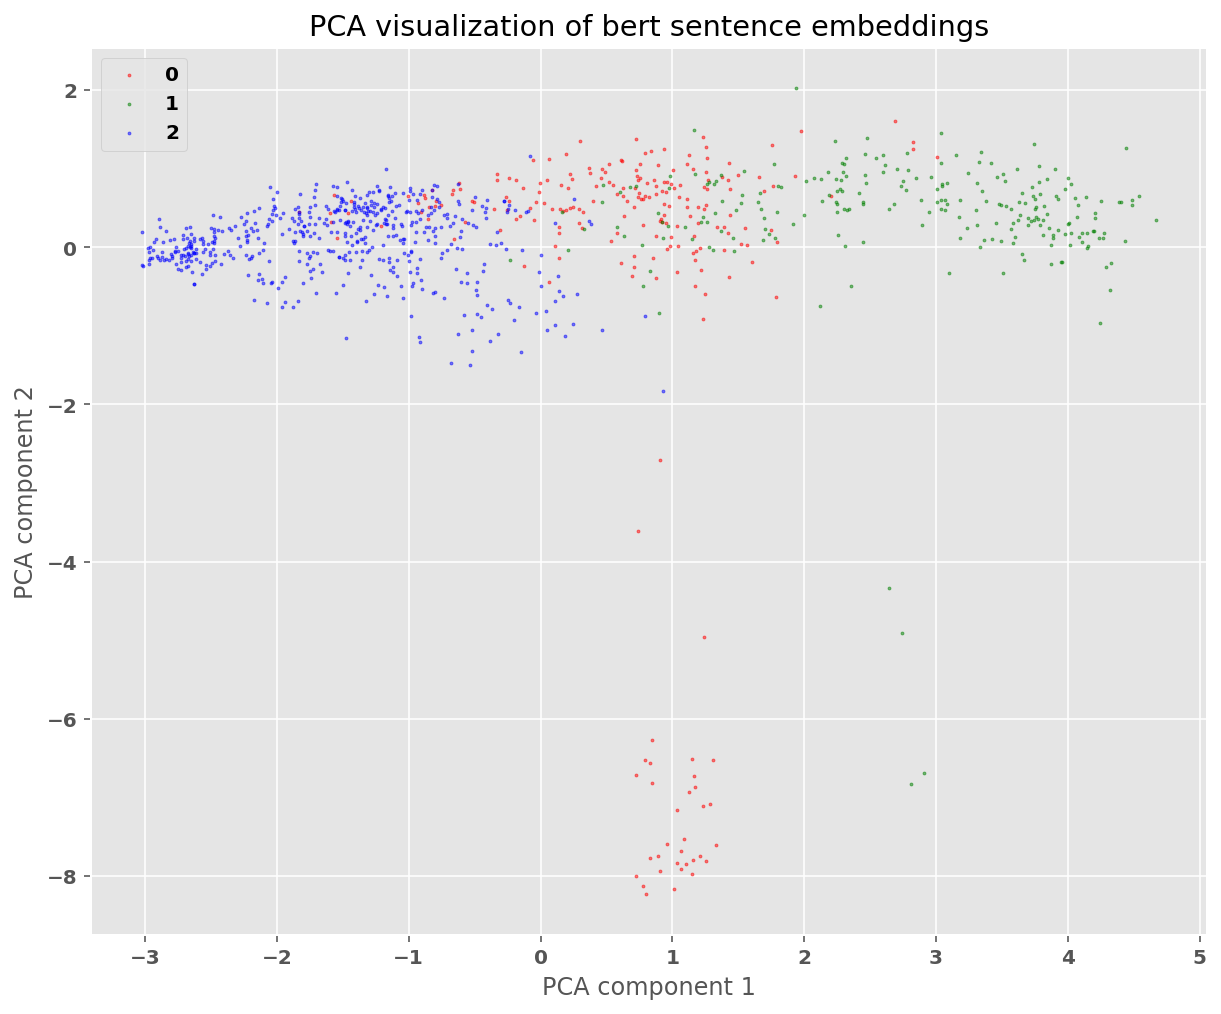

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))

# Plot each subject with a different color
unique_labels = list(set(labels))
colors = ['r', 'g', 'b'][:len(unique_labels)]  # Adjust colors based on the number of unique labels

for i, label in enumerate(unique_labels):
    indices = [j for j, label_id in enumerate(labels) if label_id == label]
    plt.scatter(pca_embeddings[indices, 0], pca_embeddings[indices, 1], c=colors[i], label=label, alpha=0.5, s=2)

plt.title('PCA visualization of bert sentence embeddings')
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.legend()
plt.show()

We notice that most of the points are within a small angular spread on the 2-d plane.  This shows the inherent problem with the BERT based embeddings that exhibit a stark anisotropy.  

## Sentence Transformer Embeddings

Now, we repeat the same for a sentence transformer model **BAAI/bge-base-en-v1.5**, that has been trained on contrastive loss

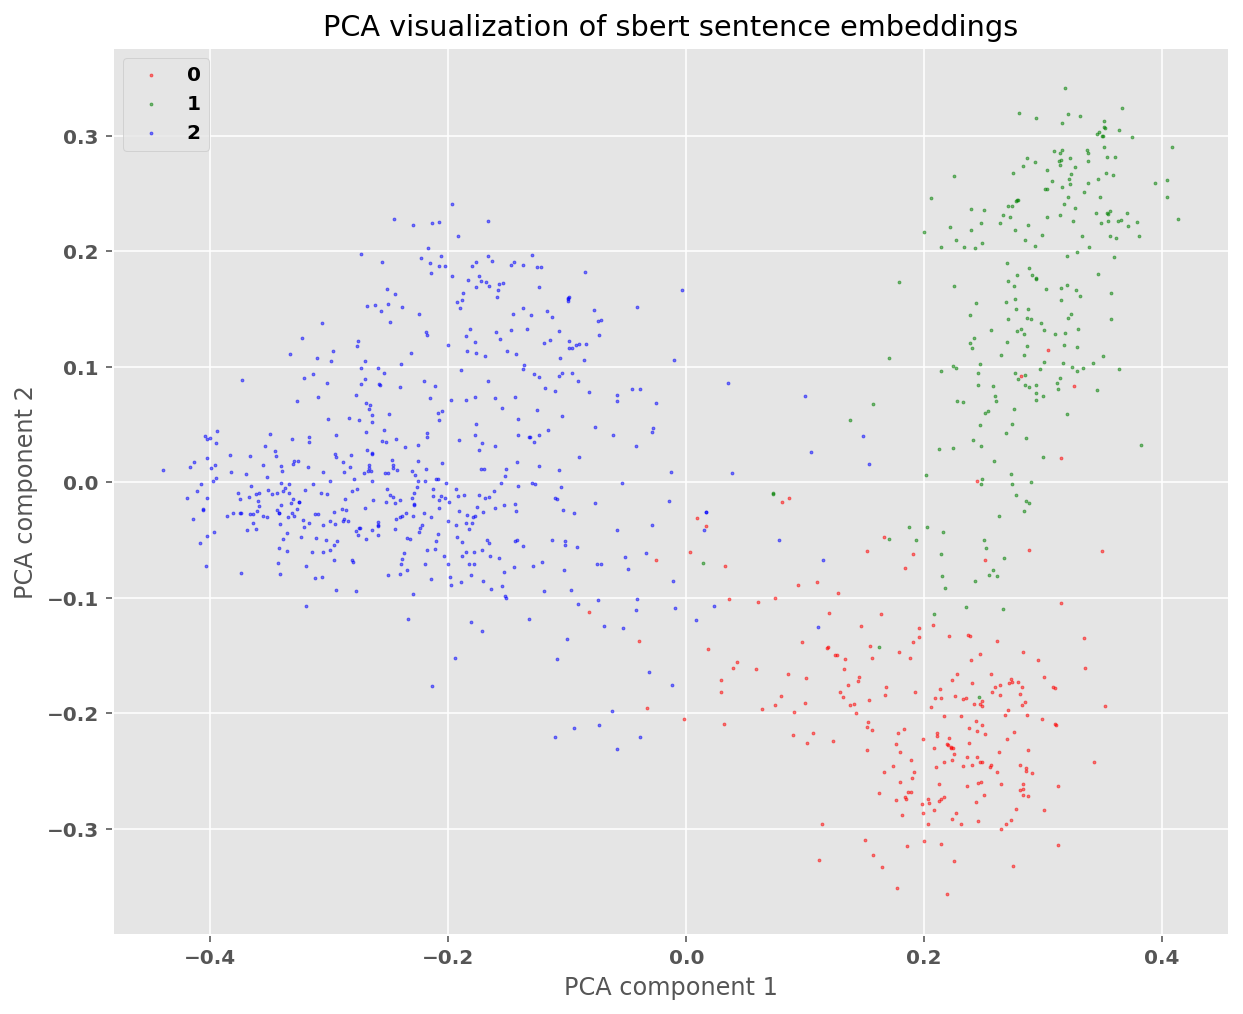

In [8]:
sbert_model = SentenceTransformer('BAAI/bge-base-en-v1.5').to(device)
sbert_embeddings = sbert_model.encode(data_sentences)
sbert_pca = PCA(n_components=2, random_state=42)
sbert_pca_embeddings = sbert_pca.fit_transform(sbert_embeddings)
plt.figure(figsize=(10, 8))
for i, label in enumerate(unique_labels):
    indices = [j for j, label_id in enumerate(labels) if label_id == label]
    plt.scatter(sbert_pca_embeddings[indices, 0], sbert_pca_embeddings[indices, 1], c=colors[i], label=label, alpha=0.5, s=2)

plt.title('PCA visualization of sbert sentence embeddings')
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.legend()
plt.show()


## Fine-tuned Sentence Transformer Embeddings

### CoSENTLoss based fine-tuning

We now fine-tune the model further for this specific dataset.  This is done by adding a contrastive loss term that brings sentence pairs with same subjects closer together and sentence pairs from different subjects farther apart.  We do this for various `scales` (inverse `temperatures`) to demonstrate how the embeddings move away as `scale` increases (`temperature` decreases).

The fine-tuning code is at [sbert_subjects_cosent_ft.py](../../src/contrastive_loss/sbert_subjects_cosent_ft.py).  The fine-tuned models are saved in the path specified in `config.yaml`.  

We now load the fine-tuned model from this path and repeat the visualization of these embeddings.

**NOTE**: The below cell can be run only after running the fine-tuning code (by running `uv run ./src/contrastive_loss/sbert_subjects_cosent_ft.py`)

Using latest checkpoint for scale 5: /Users/chandarl/results/subject-based-encoder-sbert_scale_5/checkpoint-2000


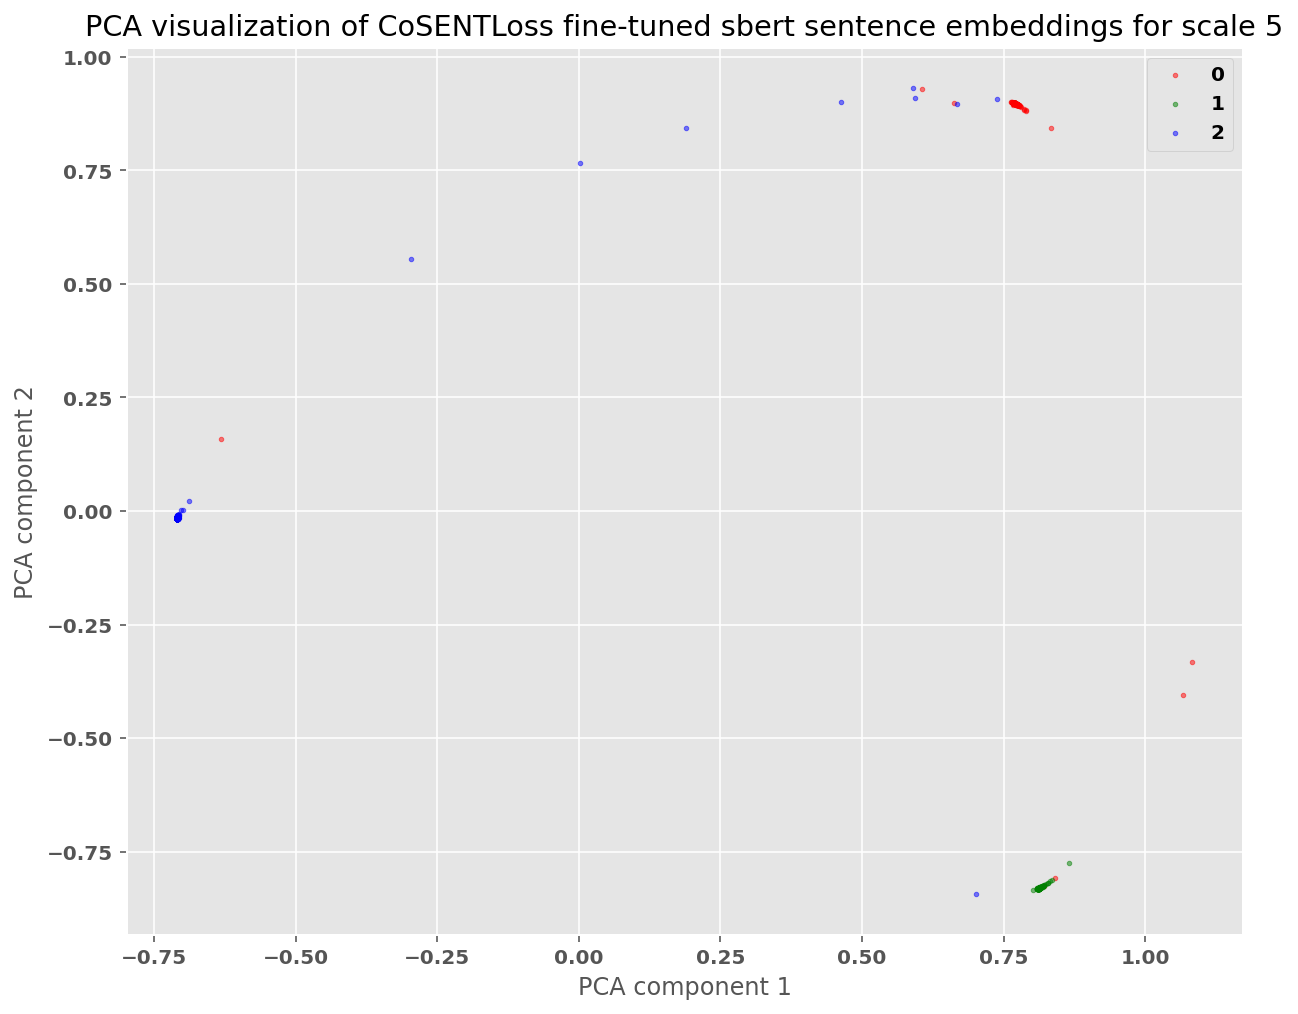

Using latest checkpoint for scale 20: /Users/chandarl/results/subject-based-encoder-sbert_scale_20/checkpoint-2000


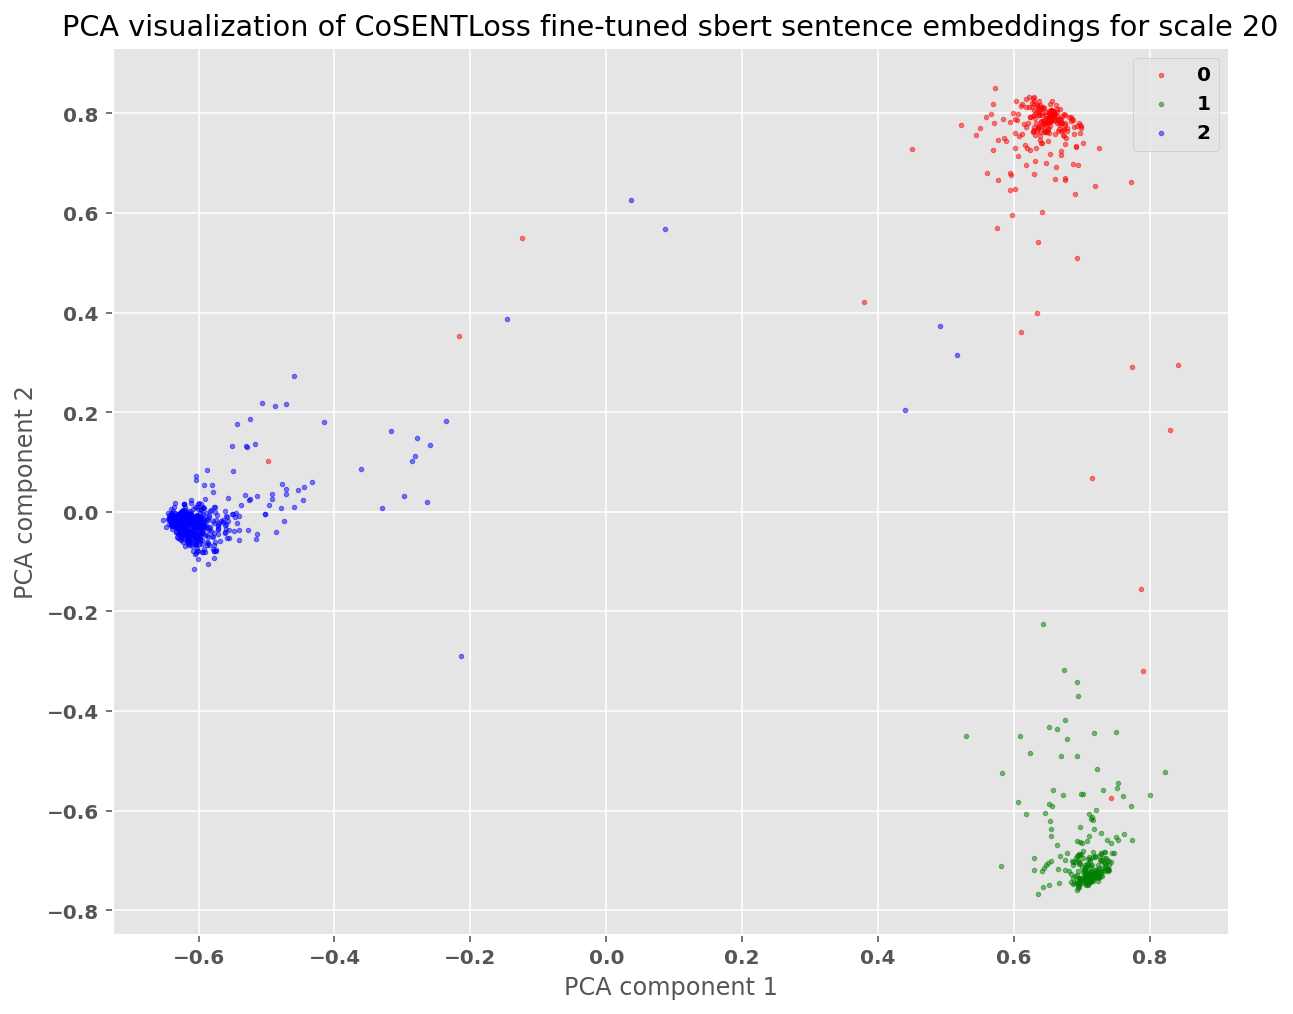

In [9]:
import glob

results_dir = config["paths"]["results_dir"]
results_sub_dir = config["paths"]["results_sub_dir_cosent"]

scales = [5, 20]
for scale in scales:
    # Find the latest checkpoint directory
    checkpoint_pattern = f'{results_dir}/{results_sub_dir}_scale_{scale}/checkpoint-*' 
    checkpoint_dirs = glob.glob(checkpoint_pattern)

    # Sort by directory name (which includes the step number) and get the latest
    latest_checkpoint = sorted(checkpoint_dirs, key=lambda x: int(x.split('checkpoint-')[-1]))[-1]
    finetuned_model_dir = latest_checkpoint
    print(f"Using latest checkpoint for scale {scale}: {finetuned_model_dir}")

    finetuned_model = SentenceTransformer(finetuned_model_dir)
    finetuned_embeddings = finetuned_model.encode(data_sentences)
    finetuned_pca = PCA(n_components=2, random_state=42)
    finetuned_pca_embeddings = finetuned_pca.fit_transform(finetuned_embeddings)
    plt.figure(figsize=(10, 8))
    for i, label in enumerate(unique_labels):
        indices = [j for j, label_id in enumerate(labels) if label_id == label]
        plt.scatter(finetuned_pca_embeddings[indices, 0], finetuned_pca_embeddings[indices, 1], c=colors[i], label=label, alpha=0.5, s=5)

    plt.title(f'PCA visualization of CoSENTLoss fine-tuned sbert sentence embeddings for scale {scale}')
    plt.xlabel('PCA component 1')
    plt.ylabel('PCA component 2')
    plt.legend()
    plt.show()    

As we see, fine-tuning the model on such a contrastive loss has achieved in a remarkable separation of the embeddings into three different clusters where it is very unlikely that one can be mistaken for the other.

### InfoNCE loss based fine-tuning


The fine-tuning code is at [sbert_subjects_infonce_ft.py](../../src/contrastive_loss/sbert_subjects_infonce_ft.py).  The fine-tuned models are saved in the path specified in `config.yaml`.  

We now load the fine-tuned model from this path and repeat the visualization of these embeddings.

**NOTE**: The below cell can be run only after running the fine-tuning code (by running `uv run ./src/contrastive_loss/sbert_subjects_infonce_ft.py`)

Using latest checkpoint for scale 5: /Users/chandarl/results/subject-based-encoder-sbert-infonce_scale_5/checkpoint-2000


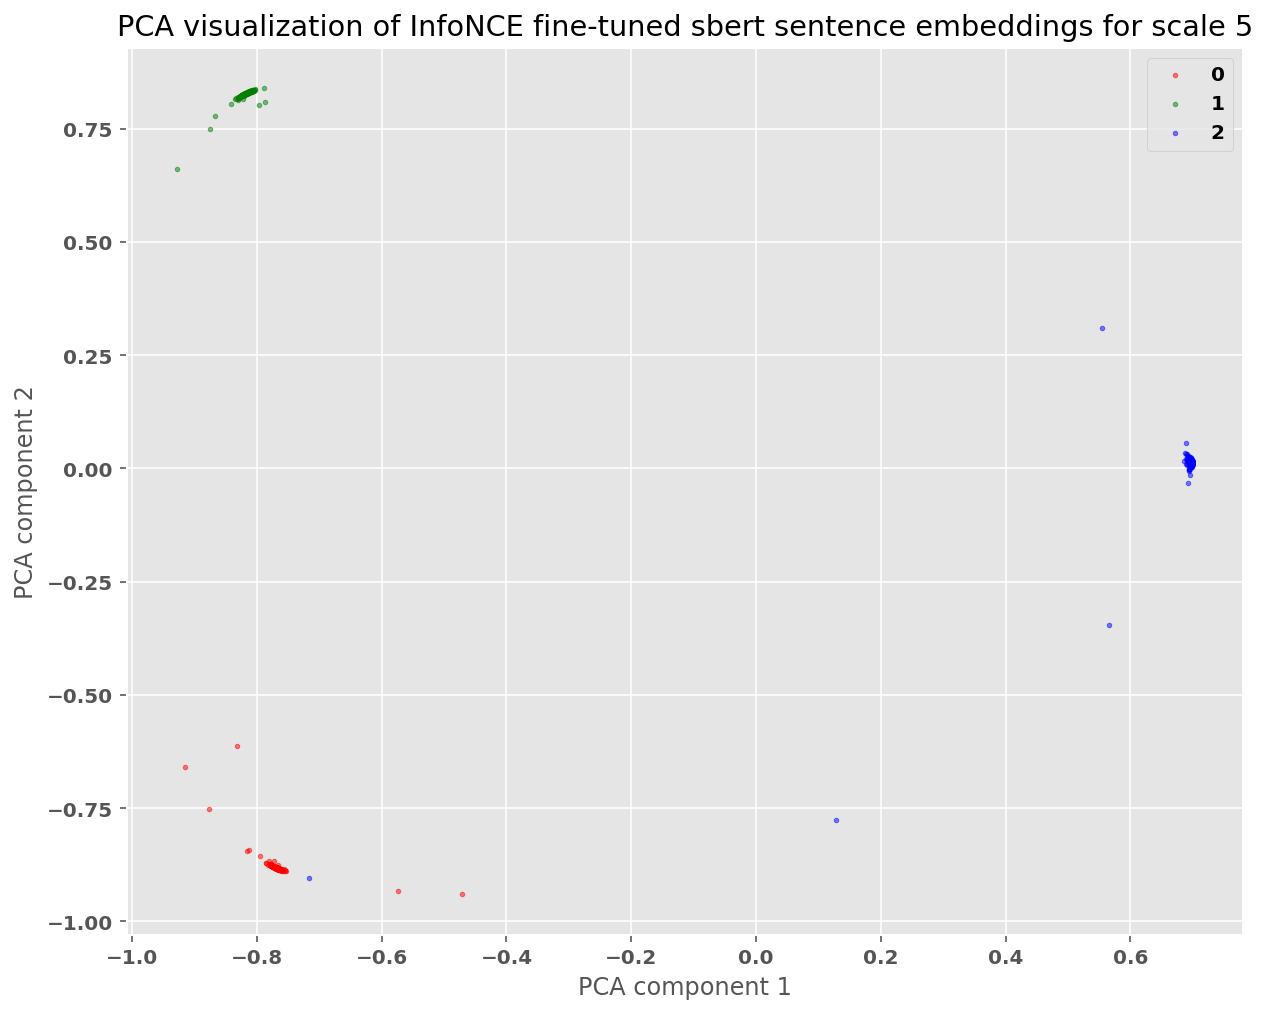

Using latest checkpoint for scale 20: /Users/chandarl/results/subject-based-encoder-sbert-infonce_scale_20/checkpoint-2000


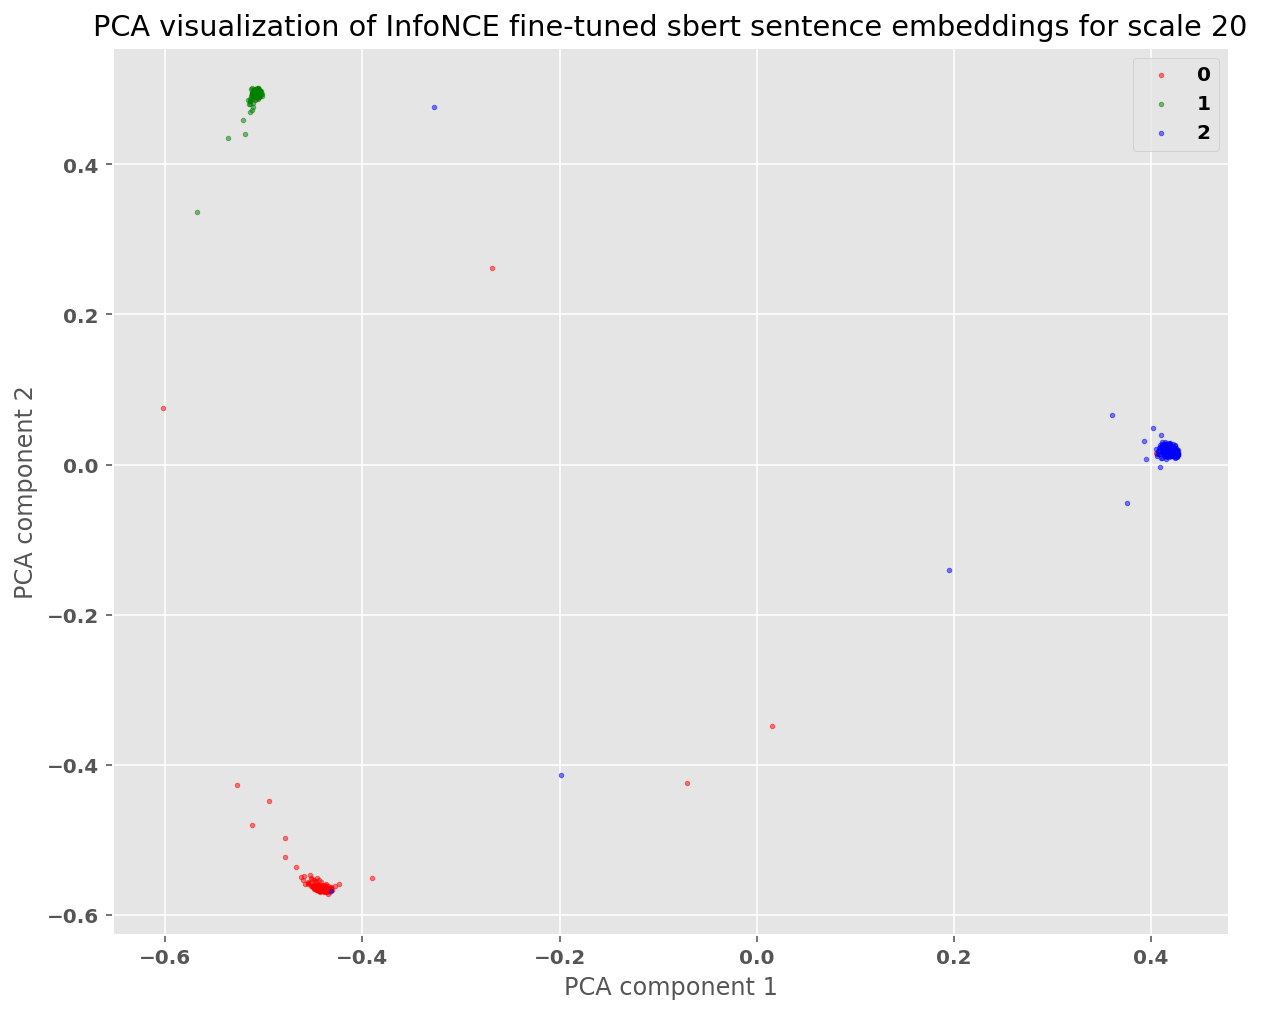

In [10]:
results_dir = config["paths"]["results_dir"]
results_sub_dir = config["paths"]["results_sub_dir_infonce"]

scales = [5, 20]
for scale in scales:
    # Find the latest checkpoint directory
    checkpoint_pattern = f'{results_dir}/{results_sub_dir}_scale_{scale}/checkpoint-*' 
    checkpoint_dirs = glob.glob(checkpoint_pattern)

    # Sort by directory name (which includes the step number) and get the latest
    latest_checkpoint = sorted(checkpoint_dirs, key=lambda x: int(x.split('checkpoint-')[-1]))[-1]
    finetuned_model_dir = latest_checkpoint
    print(f"Using latest checkpoint for scale {scale}: {finetuned_model_dir}")

    finetuned_model = SentenceTransformer(finetuned_model_dir)
    finetuned_embeddings = finetuned_model.encode(data_sentences)
    finetuned_pca = PCA(n_components=2, random_state=42)
    finetuned_pca_embeddings = finetuned_pca.fit_transform(finetuned_embeddings)
    plt.figure(figsize=(10, 8))
    for i, label in enumerate(unique_labels):
        indices = [j for j, label_id in enumerate(labels) if label_id == label]
        plt.scatter(finetuned_pca_embeddings[indices, 0], finetuned_pca_embeddings[indices, 1], c=colors[i], label=label, alpha=0.5, s=5)

    plt.title(f'PCA visualization of InfoNCE fine-tuned sbert sentence embeddings for scale {scale}')
    plt.xlabel('PCA component 1')
    plt.ylabel('PCA component 2')
    plt.legend()
    plt.show()   